# TicTacToe

Vi skal nå se på hvordan vi kan bruke TD læring til å trene en agent til å spille TicTacToe

In [1]:
import os
import sys
sys.path.append(os.getcwd())

In [2]:
%matplotlib inline
import numpy as np
import pickle
from State import all_states
from TicTacEnv import TicTacEnv
import matplotlib.pyplot as plt

Tic Tac Toe er ferdig implementert, men vi har lyst på mulighet til å spille selv

In [3]:
class HumanAgent:

    def __init__(self, **kwargs):
        self.symbol = None
        self.keys = ['q', 'w', 'e', 'a', 's', 'd', 'z', 'x', 'c']
        self.state = None

    def reset(self):
        pass

    def set_state(self, state):
        self.state = state

    def set_symbol(self, symbol):
        self.symbol = symbol

    def act(self):
        self.state.render()
        key = input("Input your position:")
        data = self.keys.index(key)
        i = data // 3
        j = data % 3
        return i, j, self.symbol

Det er ofte også nyttig med mulighet for tilfeldige handlinger

In [4]:
def get_random_move(state, symbol):
    next_states = []
    next_positions = []
    for i in range(3):
        for j in range(3):
            if state.board[i, j] == 0:
                next_positions.append([i, j])
                next_states.append(state.next_state(i, j, symbol).hash())
    
    action = next_positions[np.random.randint(len(next_positions))]
    action.append(symbol)
    return action
    

Vi lager en agent som kan spille tilfeldig

In [5]:
class RandomAgent:
    def __init__(self, **kwargs):
        self.symbol = None
        self.state = None
        
    def reset(self):
        pass

    def set_state(self, state):
        self.state = state

    def set_symbol(self, symbol):
        self.symbol = symbol

    def act(self):
        return get_random_move(self.state, self.symbol)

Og mulighet til å spille mot tifleldig agenten som spiller tilfeldig

In [6]:
def play():
    for i in range(2):
        # Load agents
        player1 = HumanAgent()
        player2 = RandomAgent()
        # Load environment
        env = TicTacEnv(player1, player2)
        # Play the game
        winner = env.play()
        if winner == player2.symbol:
            print("You lose!")
        elif winner == player1.symbol:
            print("You win!")
        else:
            print("It is a tie!")

Show the random agent what you are made of!

In [7]:
play()

-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


Input your position: s


-------------
| 0 | 0 | x | 
-------------
| 0 | * | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


Input your position: w


-------------
| 0 | * | x | 
-------------
| 0 | * | 0 | 
-------------
| 0 | x | 0 | 
-------------


Input your position: c


-------------
| 0 | * | x | 
-------------
| 0 | * | 0 | 
-------------
| x | x | * | 
-------------


Input your position: q


You win!
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


KeyboardInterrupt: Interrupted by user

Lets play the random agent against itself

In [8]:
def compete(turns):
    player1 = RandomAgent()
    player2 = RandomAgent()
    env = TicTacEnv(player1, player2)
    player1_win = 0.0
    player2_win = 0.0
    tie = 0.0
    for _ in range(turns):
        winner = env.play()
        if winner == 1:
            player1_win += 1
        elif winner == -1:
            player2_win += 1
        else:
            tie += 1
        env.reset()
    print('%d turns, player 1 win %.02f, player 2 win %.02f, tied %.02f'% (turns, player1_win / turns, player2_win / turns, tie / turns))

In [9]:
compete(100)

100 turns, player 1 win 0.61, player 2 win 0.24, tied 0.15


How did it do? Was it what you would expect?

## RL agent

This is where most of your code will go.

Fill inn all the TODOs
Feel free to ask questions

In [10]:
class Agent:

    def __init__(self, learning_rate=0.1, epsilon=0.1):
        self.value_table = dict()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.states = []
        self.greedy = []
        self.symbol = 0

    def reset(self):
        # Reset the agents so its ready for a new episode
        self.states = []
        self.greedy = []

    def set_state(self, state):
        self.states.append(state)
        self.greedy.append(True)

    def set_symbol(self, symbol):
        # Set the symbol the agent will use
        self.symbol = symbol
        for hash_val in all_states:
            state, is_end = all_states[hash_val]
            if is_end:
                if state.winner == self.symbol:
                    self.value_table[hash_val] = 1.0
                elif state.winner == 0:
                    # we need to distinguish between a tie and a lose
                    self.value_table[hash_val] = 0.5
                else:
                    self.value_table[hash_val] = 0
            else:
                self.value_table[hash_val] = 0.5

    def backup(self):
        # Back up the values we have encountered
        states = [state.hash() for state in self.states]

        for i in reversed(range(len(states) - 1)):
            # For each state we want to compute the TD error or "Surprise" of the system
            state = states[i]
            td_error = self.greedy[i] * (self.value_table[states[i + 1]] - self.value_table[state])
            self.value_table[state] += self.learning_rate * td_error

    def act(self):
        # Selecting an action for the agent to performe
        state = self.states[-1]
        next_states = []
        next_positions = []
        for i in range(3):
            for j in range(3):
                if state.board[i, j] == 0:
                    next_positions.append([i, j])
                    next_states.append(state.next_state(i, j, self.symbol).hash())

        # If we have random less than epsilon we select an action randomly
        if np.random.rand() < self.epsilon:
            action = next_positions[np.random.randint(len(next_positions))]
            action.append(self.symbol)
            self.greedy[-1] = False
            return action

        # Find our values for the next states
        values = []
        for hash_val, pos in zip(next_states, next_positions):
            values.append((self.value_table[hash_val], pos))

        # Lets sort all next states in decreasing value order
        np.random.shuffle(values)
        values.sort(key=lambda x: x[0], reverse=True)
        action = values[0][1]
        action.append(self.symbol)
        # Return action that leads to the next state with highest value
        return action

    # It is very usefull to save our policy when we are done training
    def save_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'wb') as f:
            pickle.dump(self.value_table, f)

    # Likewise it is nice to be able to load our policy again
    def load_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'rb') as f:
            self.value_table = pickle.load(f)

Now that we have the agent, we need to train it to play the game
Again fill in the TODOs

In [11]:
class Trainer:

    @staticmethod
    def train(epochs, print_interval=500):
        # Initialize the agents
        p1 = Agent(epsilon=0.01)
        p2 = Agent(epsilon=0.01)

        # Initialize the environment
        env = TicTacEnv(p1, p2)
        p1_wins = 0
        p2_wins = 0

        p1_100 = 0
        p2_100 = 0
        p1_history = []
        p2_history = []
        tie_history = []

        # for each episode
        for i in range(1, epochs + 1):
            # Play a round and append the results
            winner = env.play(print_state=False)
            if winner == 1:
                p1_wins += 1
                p1_100 += 1
            if winner == -1:
                p2_wins += 1
                p2_100 += 1
            # Print ocationaly
            if i % print_interval == 0:
                print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (
                    i, p1_wins / i, p2_wins / i))
            if i % 250 == 0:
                p1_history.append(p1_100 / 250)
                p2_history.append(p2_100 / 250)
                tie_history.append((250 - p1_100 - p2_100) / 250)
                p1_100 = 0
                p2_100 = 0

            # Train our agents
            p1.backup()
            p2.backup()

            # Reset the envoronment
            env.reset()

        # Save the policies
        p1.save_policy()
        p2.save_policy()

        # Plot the training hisory
        plt.plot(p1_history, label="p1")
        plt.plot(p2_history, label="p2")
        plt.plot(tie_history, label="tie")
        plt.legend()
        plt.show()

Epoch 100, player 1 winrate: 0.70, player 2 winrate: 0.23
Epoch 200, player 1 winrate: 0.47, player 2 winrate: 0.12
Epoch 300, player 1 winrate: 0.33, player 2 winrate: 0.09
Epoch 400, player 1 winrate: 0.26, player 2 winrate: 0.07
Epoch 500, player 1 winrate: 0.23, player 2 winrate: 0.06
Epoch 600, player 1 winrate: 0.19, player 2 winrate: 0.05
Epoch 700, player 1 winrate: 0.17, player 2 winrate: 0.04
Epoch 800, player 1 winrate: 0.16, player 2 winrate: 0.05
Epoch 900, player 1 winrate: 0.15, player 2 winrate: 0.05
Epoch 1000, player 1 winrate: 0.14, player 2 winrate: 0.04
Epoch 1100, player 1 winrate: 0.14, player 2 winrate: 0.04
Epoch 1200, player 1 winrate: 0.13, player 2 winrate: 0.04
Epoch 1300, player 1 winrate: 0.12, player 2 winrate: 0.04
Epoch 1400, player 1 winrate: 0.12, player 2 winrate: 0.04
Epoch 1500, player 1 winrate: 0.11, player 2 winrate: 0.04
Epoch 1600, player 1 winrate: 0.12, player 2 winrate: 0.04
Epoch 1700, player 1 winrate: 0.11, player 2 winrate: 0.04
Epoch 

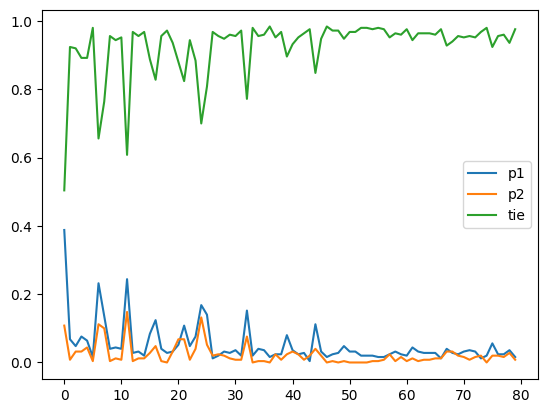

In [12]:
Trainer.train(20000, print_interval=100)

Lets test the two agents agains eachother

In [13]:
def compete(turns):
    player1 = Agent(epsilon=0)
    player2 = Agent(epsilon=0)
    env = TicTacEnv(player1, player2)
    player1.load_policy()
    player2.load_policy()
    player1_win = 0.0
    player2_win = 0.0
    for _ in range(turns):
        winner = env.play()
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        env.reset()
    print('%d turns, player 1 win %.02f, player 2 win %.02f' % (turns, player1_win / turns, player2_win / turns))


In [14]:
compete(int(1e3))

1000 turns, player 1 win 0.00, player 2 win 0.00


How did it go? Did it play as expected?

Play against it yourself!

In [15]:
def play():
    for i in range(2):
        player1 = HumanAgent()
        player2 = Agent(epsilon=0)
        env = TicTacEnv(player1, player2)
        player2.load_policy()
        winner = env.play()
        if winner == player2.symbol:
            print("You lose!")
        elif winner == player1.symbol:
            print("You win!")
        else:
            print("It is a tie!")

In [ ]:
play()

-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


Input your position: s


-------------
| x | 0 | 0 | 
-------------
| 0 | * | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


Input your position: w


-------------
| x | * | 0 | 
-------------
| 0 | * | 0 | 
-------------
| 0 | x | 0 | 
-------------


Input your position: z


-------------
| x | * | x | 
-------------
| 0 | * | 0 | 
-------------
| * | x | 0 | 
-------------


Input your position: c


-------------
| x | * | x | 
-------------
| 0 | * | x | 
-------------
| * | x | * | 
-------------


Input your position: a


It is a tie!
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


Done?

Try to train if for longer, shorter.